<a href="https://colab.research.google.com/github/xjseabrum/comp_disc_S22_proj/blob/main/main_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SET UP

In [1]:
!python3 --version

Python 3.7.13


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os as os
os.chdir("/content/gdrive/MyDrive/comp_proj")

In [4]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 256 kB 40.1 MB/s 
     |████████████████████████████████| 4.0 MB 58.2 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 880 kB 61.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=abbc662d52ebb16d72d06f9ad4558664e1bebc7f368b8c0d4a2f8791d6809c1f
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0e8dfb30c8045addcc39f709a56c5d1b7f148ed2dd6f5f2536122891c333042f
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295

In [5]:
# A Python interface to the Penn Discourse Treebank 2
!git clone https://github.com/cgpotts/pdtb2.git

fatal: destination path 'pdtb2' already exists and is not an empty directory.


In [6]:
os.chdir("/content/gdrive/MyDrive/comp_proj/pdtb2")

In [7]:
#import statements
from sklearn.cluster import KMeans
import numpy as np
from pdtb2 import CorpusReader, Datum
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle

# Data Extraction and Preprocessing

In [ ]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

model_sent = SentenceTransformer('all-mpnet-base-v2')
qa_search = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
semantic_serch = SentenceTransformer('sentence-transformers/msmarco-distilbert-dot-v5')# not good

def sent_transformer(sentences, embedding_scheme = qa_search):
  embeddings = embedding_scheme.encode(sentences)
  return embeddings


In [9]:
#Read in Data
X_sentences = []
y = []
rel_tag = []
iterator = CorpusReader('pdtb2.csv').iter_data(display_progress=False)
try:
    while(True):
        d = next(iterator)
        arg1 = d.Arg2_RawText
        arg2 = d.Arg2_Attribution_RawText
        relation = d.Relation
        connection = None
        if relation == "Explicit":
            connection = str(d.ConnHead).lower()
            X_sentences.append([str(d.Arg1_RawText).lower(),
                                str(d.ConnHead).lower(),
                                str(d.Arg2_RawText).lower()])
            y.append(str(d.ConnHead).lower())
            rel_tag.append(str(d.ConnHeadSemClass1).lower())
        '''
        if relation=="Implicit":
            connection=d.Conn1
            X_sentences.append([d.Arg1_RawText,connection,d.Arg2_RawText])
            y.append(connection)
        '''
except:
    print("end")

end


In [10]:
len(X_sentences)

18459

In [11]:
def concate(arg1,conn,arg2):
    return np.concatenate([arg1,conn,arg2])
def similarity(arg1,conn,arg2):
    return np.concatenate([arg1, conn, arg2, np.absolute(np.subtract(arg1,arg2)), [np.dot(arg1,arg2)]])
def dot_product(arg1,conn,arg2):
    return [np.dot(arg1,arg2)]
n=len(X_sentences)

In [12]:
# extract features use bert sentence transformers and concatenate two embedings.
# reference : https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# save features to file because it cost a lot of time extracting the features

n = len(X_sentences)
filename = "features.npy"

if os.path.exists(filename):
    print("{} already exists.  Loading in the file...".format(filename))
    # load features from file
    X = []
    with open(filename, 'rb') as f:
        for _ in range(n):
            X.append(np.load(f,allow_pickle=True))
else: 
    with open(filename, 'wb') as f:
        c = 1
        start = time.time()
        for sentences in X_sentences:
            arg1, conn, arg2 = sent_transformer(sentences)
            feature = concate(arg1, conn, arg2)
            np.save(f, feature)
            if c % 1000 == 0:
                print(str(c) + "/" + str(n) + " complete.")
            if c % n == 0:
                print(str(c) + "/" + str(n) + " complete.")
            c += 1
        end = time.time()
        print("Total runtime: {} seconds".format(round(end - start, 2)))
    X = []
    with open(filename, 'rb') as f:
        for _ in range(n):
            X.append(np.load(f,allow_pickle=True))

features.npy already exists.  Loading in the file...


In [13]:
class ViewLabels:
    def __init__(self, X, X_sentences, algo_labels, u, level):
      self.level = level
      self.u = u
      
      arg1s = [x[0] for x in X_sentences]
      arg2s = [x[2] for x in X_sentences]
      arg_conn = [x[1] for x in X_sentences]
      arg_label = [y for y in rel_tag]
      df = pd.DataFrame([arg1s, arg2s, arg_conn, algo_labels, arg_label]).transpose()
      df.columns = ['arg1','arg2','connective', 'algo', 'pdtb_tag']

      df[['primary', 'secondary', 'tertiary']] = df.pdtb_tag.str.split('.', expand=True)
      df['primary'] = df['primary'].fillna("<empty_1>")
      df['secondary'] = df['secondary'].fillna("<empty_2>")
      df['tertiary'] = df['tertiary'].fillna("<empty_3>")
      
      self.df = df

    def get_df(self):
        return self.df

    def get_algo_labels(self):
        labels = []
        for label in range(self.u):
          df2 = self.df[self.df['algo'] == label]
          tmp_list1 = set(df2["connective"])
          [x, y] = [label, [tmp_list1]]
          labels.append([x,y])
        return labels

    def get_connective_to_algo(self):
        connective_to_algo = []
        for word in range(len(list(set(self.df["connective"])))):
          connective = list(set(self.df["connective"]))[word] 
          df2 = self.df[self.df["connective"] == connective]
          tmp_list2 = set(df2["algo"])
          [x,y] = [connective, [tmp_list2]]
          connective_to_algo.append([x,y])
        return connective_to_algo

    def get_connective_to_pdtb_label(self):
        pdtb_connective_to_pdtb_label = []
        for word in range(len(list(set(self.df["connective"])))):
          connective = list(set(self.df["connective"]))[word] 
          df2 = self.df[self.df["connective"] == connective]
          tmp_list3 = set(df2[self.level])
          [x,y] = [connective, [tmp_list3]]
          pdtb_connective_to_pdtb_label.append([x,y])
        return pdtb_connective_to_pdtb_label

    def get_pdtb_label_to_connective(self):
      pdtb_label_to_connective = []
      for label in range(len(list(set(self.df[self.level])))):
        label_word = list(set(self.df[self.level]))[label]
        df2 = self.df[self.df[self.level] == label_word]
        tmp_list4 = set(df2["connective"])
        [x, y] = [label_word, [tmp_list4]]
        pdtb_label_to_connective.append([x,y])
      return pdtb_label_to_connective

    def get_algo_to_pdtb_label_mapping(self):
      algo_to_pdtb = []
      for label in range(self.u):
        df2 = self.df[self.df['algo'] == label]
        tmp_list5 = set(df2[self.level])
        [x, y] = [label, [tmp_list5]]
        algo_to_pdtb.append([x,y])
      return algo_to_pdtb

    def get_pdtb_label_to_algo_mapping(self):
      pdtb_to_algo = []
      for label in range(len(list(set(self.df[self.level])))):
        label_word = list(set(self.df[self.level]))[label]
        df2 = self.df[self.df[self.level] == label_word]
        tmp_list6 = set(df2["algo"])
        [x, y] = [label_word, [tmp_list6]]
        pdtb_to_algo.append([x,y])
      return pdtb_to_algo

# KMEANS

## Kmeans- range

In [14]:
# Run naive kmeans. 
# Save the distortions file so as to not run this again
# as it takes 17 minutes to run
from kneed import KneeLocator

class GetOptimalClusters:
    def __init__(self, filename, representation_list, max_clusters):
        self.filename = filename
        self.representation_list = representation_list
        self.K = range(1, max_clusters + 1)
        self.distortions = []
        self.knee = 1
        self.__run()

    def __check_file_exists(self):
        return os.path.exists(self.filename)
    
    def __clear_distortions(self):
        self.distortions = []

    def __calculate_distortions(self):
        if self.__check_file_exists() == False:
            self.__clear_distortions()
            for k in self.K:
                kmeanModel = KMeans(n_clusters = k)
                kmeanModel.fit(self.representation_list)
                self.distortions.append(kmeanModel.inertia_)
            with open(self.filename, 'wb') as pickle_file:
                pickle.dump(self.distortions, pickle_file, 
                            protocol = pickle.HIGHEST_PROTOCOL)
        else:
            print("{} exists.  Loading it in...".format(self.filename))
            self.__clear_distortions()
            with open(self.filename, 'rb') as pickle_file:
                self.distortions = pickle.load(pickle_file)

    def __graph_output(self):
        fig1 = plt.figure(figsize=(16,8))
        plt.plot(self.K, self.distortions, 'b-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method showing the optimal k')
        plt.show()

    def __calculate_knee(self):
        #use knee locater to locate elbow point
        # interp_method is used for exp curves:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
        # polynomial for polynomials
        # The k-means plot is more exponential than polynomial
        # so switching to interp1d (as for now it doesn't change
        # the knee value: it's still 9 with or without interp1d)

        # Read more about the parameters for knees here:
        # https://kneed.readthedocs.io/en/stable/parameters.html
        # As we currently have out sensitivity set to 1.
        i = np.arange(len(self.distortions))
        self.knee = KneeLocator(i, self.distortions, 
                            S = 1, curve='convex', 
                            direction='decreasing', 
                            interp_method='interp1d')
        fig2 = plt.figure(figsize=(5, 5))
        self.knee.plot_knee()
        plt.xlabel("k")
        plt.ylabel("Distortion")

    def __show_optimal(self):
        print("Optimal number of groups: {}".format(self.knee.knee))

    def __run(self):
        self.__calculate_distortions()
        self.__graph_output()
        self.__calculate_knee()
        self.__show_optimal()

distortions.pkl exists.  Loading it in...


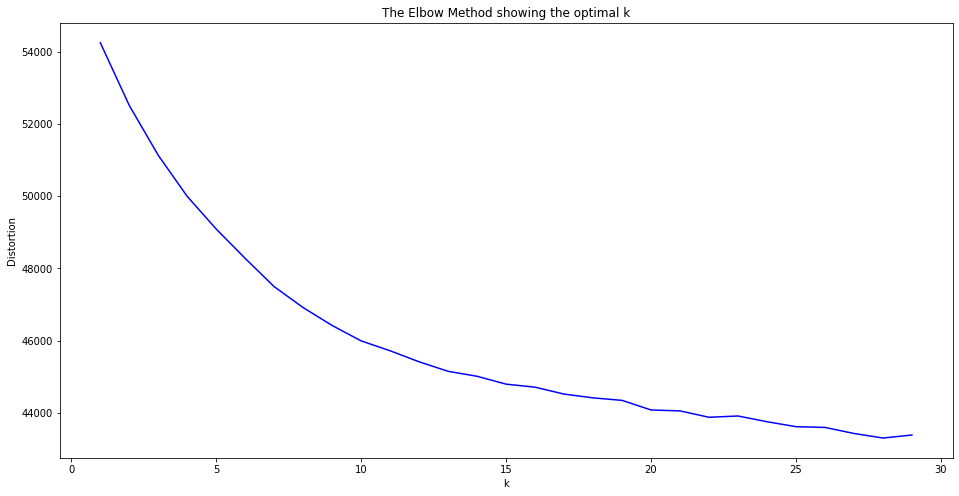

Optimal number of groups: 9


<Figure size 360x360 with 0 Axes>

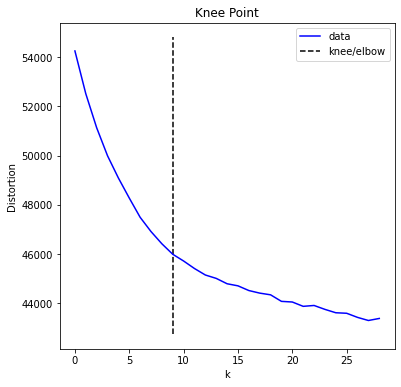

In [15]:
GetOptimalClusters(filename = "distortions.pkl", 
                         representation_list = X, 
                         max_clusters = 29)

## KMeans - individual

In [16]:
class RunKMeans:
    def __init__(self, u, random_state, X, X_sentences, rel_tag, 
                 level = "secondary"):
        self.u = u
        self.random_state = random_state
        self.X = X
        self.X_sentences = X_sentences
        self.kmeans = []
        self.level = level
        self.df = None
        self.generated_labels = None
        self.rel_tag = rel_tag
        self.df_count = None
        self.__execute()

    def __run_algo(self):
        kmeans = KMeans(n_clusters = self.u, 
                        random_state = self.random_state).fit(self.X)
        self.kmeans = kmeans
    
    def __call_labels(self):
        generated_labels = ViewLabels(self.X, self.X_sentences, 
                                      self.kmeans.labels_, self.u, 
                                      self.level)
        self.generated_labels = generated_labels
    
    def __output_dataframe(self):
        labels_K = self.generated_labels.get_algo_labels()
        cols = [i for i in range(self.u)]
        connective_clusters = [list(x[1][0]) for x in labels_K]
        df = pd.DataFrame(connective_clusters).transpose()
        df.columns = cols
        self.df = df

    def __count_labels(self):
        cols = ["kmeans_label", "primary_tag", "secondary_tag", "tertiary_tag"]
        df_tmp = pd.DataFrame(columns=cols, )
        for i in range(len(self.rel_tag)):
            tag_split = self.rel_tag[i].split(".")
            if len(tag_split) == 3:
                pri, sec, ter = tag_split[0], tag_split[1], tag_split[2]
            elif len(tag_split) == 2:
                pri, sec, ter = tag_split[0], tag_split[1], f"S: {tag_split[1]}"
            else:
                pri, sec, ter = tag_split[0], f"P: {tag_split[0]}",  f"P: {tag_split[0]}"
                
            df_tmp = df_tmp.append({
                          "kmeans_label":self.kmeans.labels_[i],
                          "primary_tag":pri,
                          "secondary_tag":sec,
                          "tertiary_tag":ter
                          },ignore_index=True)

        df_count = df_tmp.groupby(['kmeans_label',
                                      f"{self.level}_tag"]).size().reset_index(name='counts')
  
        self.df_count = df_count

    def __execute(self):
        self.__run_algo()
        self.__call_labels()
        self.__output_dataframe()
        self.__count_labels()

    def show_piechart(self):
        for i in range(self.u):
            df_by_klabel = self.df_count.loc[self.df_count['kmeans_label'] == i]
            total_number = df_by_klabel["counts"].sum()
            plt = df_by_klabel.set_index(f"{self.level}_tag").plot.pie(y = 'counts', 
                                                                   figsize = (10, 10),
                                                                   fontsize = 10)
            plt.set_title("K-means label: {}, Num. Sentences: {}".format(i, total_number))

    def get_kmeans_data(self):
        return self.kmeans

    def get_algo_to_conn_frame(self):
        return self.df
    
    def get_cluster_number(self):
        return self.u
    
    def get_count_frame(self):
        return self.df_count
      
    def get_transpose_count_frame(self):
        cols=set(self.df_count[f"{self.level}_tag"].to_list())
        t_df=pd.DataFrame(columns=cols,index=[x for x in range(self.u)])
        for index, row in self.df_count.iterrows():
            idx=row["kmeans_label"]
            col=row[f"{self.level}_tag"]
            val=row["counts"]
            t_df.loc[idx].loc[col]=val
        t_df=t_df.fillna(0)
        return t_df
    
    def get_generated_class_object(self):
        return self.generated_labels

In [17]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
km = RunKMeans(u = 9, 
               random_state = 0,
               X = X,
               X_sentences = X_sentences, 
               rel_tag = rel_tag)

In [20]:
km.get_transpose_count_frame().T

,0,1,2,3,4,5,6,7,8
contrast,22,2779,2,1,1018,1,16,0,5
pragmatic concession,0,5,0,0,5,0,0,0,1
pragmatic contrast,0,17,0,0,0,0,0,0,1
P: expansion,2,2,0,2,5,0,3,0,10
condition,3,0,148,16,1,0,23,0,1165
instantiation,1,0,0,0,301,0,0,0,0
pragmatic cause,0,0,0,2,4,0,0,2,0
exception,0,11,0,0,1,0,2,0,0
alternative,89,3,2,4,116,7,41,0,89
P: comparison,0,311,0,2,78,0,5,0,1


### Pivot Tables for summarization

In [63]:
class Pivot:
    def __init__(self, dataframe, index = ["primary", "secondary"]):
        self.dataframe = dataframe
        self.table = None
        self.index = index
        self.__setup()
        self.__create_table()      

    def __setup(self):
        self.dataframe["count"] = 1
        # The frame still has labels such as "<empty_2>"
        # so this part of the code replaces them with the next available label
        prim_list = list(self.dataframe["primary"])
        sec_list = list(self.dataframe["secondary"])
        ter_list = list(self.dataframe["tertiary"])
        for item in range(len(prim_list)):
            if ter_list[item] == "<empty_3>" and sec_list[item] != "<empty_2>":
                ter_list[item] = f"S: {sec_list[item]}"
            if ter_list[item] == "<empty_3>" and sec_list[item] == "<empty_2>":
                ter_list[item] = f"P: {prim_list[item]}"
                sec_list[item] = f"P: {prim_list[item]}"
            if sec_list[item] == "<empty_2>":
                sec_list[item] = f"P: {prim_list[item]}"
        self.dataframe["primary"] = prim_list
        self.dataframe["secondary"] = sec_list
        self.dataframe["tertiary"] = ter_list

    def __create_table(self):
        self.table = pd.pivot_table(self.dataframe, 
                                    values = 'count', 
                                    index = self.index, 
                                    columns = 'algo', 
                                    aggfunc = np.sum).fillna(0)
    def get_table(self):
        return self.table
    
    def get_column_percent_table(self):
        return (100. * self.table / self.table.sum()).round(1)


In [98]:
frame = km.get_generated_class_object().get_df()
piv = Pivot(dataframe = frame)

In [68]:
print(piv.get_table())

algo                                   0       1      2      3       4  \
primary     secondary                                                    
comparison  P: comparison            0.0   311.0    0.0    2.0    78.0   
            concession               1.0   586.0   10.0    6.0   540.0   
            contrast                22.0  2779.0    2.0    1.0  1018.0   
            pragmatic concession     0.0     5.0    0.0    0.0     5.0   
            pragmatic contrast       0.0    17.0    0.0    0.0     0.0   
contingency P: contingency           0.0     0.0    1.0    0.0     0.0   
            cause                   65.0     1.0   20.0  290.0    43.0   
            condition                3.0     0.0  148.0   16.0     1.0   
            pragmatic cause          0.0     0.0    0.0    2.0     4.0   
            pragmatic condition      2.0     0.0   13.0    0.0     0.0   
expansion   P: expansion             2.0     2.0    0.0    2.0     5.0   
            alternative             89

In [67]:
print(piv.get_column_percent_table())

algo                                 0     1     2     3     4     5     6  \
primary     secondary                                                        
comparison  P: comparison          0.0   8.2   0.0   0.2   2.7   0.0   0.2   
            concession             0.0  15.4   1.0   0.7  18.8   0.0   0.6   
            contrast               0.7  73.1   0.2   0.1  35.5   0.0   0.6   
            pragmatic concession   0.0   0.1   0.0   0.0   0.2   0.0   0.0   
            pragmatic contrast     0.0   0.4   0.0   0.0   0.0   0.0   0.0   
contingency P: contingency         0.0   0.0   0.1   0.0   0.0   0.0   0.0   
            cause                  2.1   0.0   2.0  33.5   1.5   0.0  22.1   
            condition              0.1   0.0  15.0   1.8   0.0   0.0   0.9   
            pragmatic cause        0.0   0.0   0.0   0.2   0.1   0.0   0.0   
            pragmatic condition    0.1   0.0   1.3   0.0   0.0   0.0   0.0   
expansion   P: expansion           0.1   0.1   0.0   0.2   0.2  

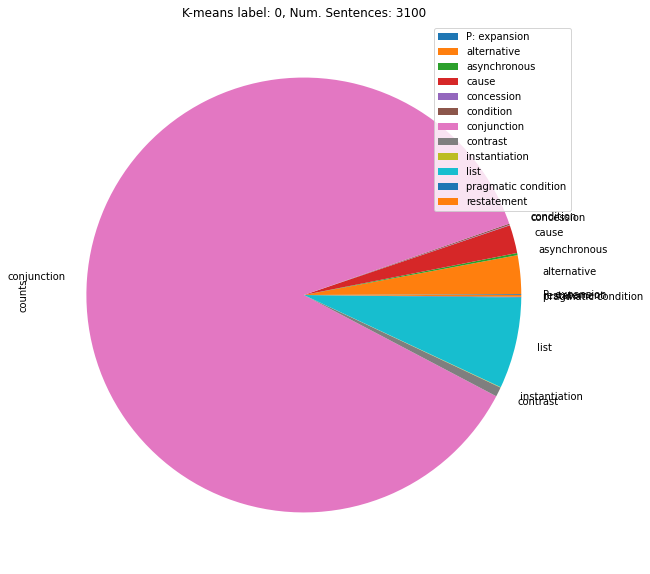

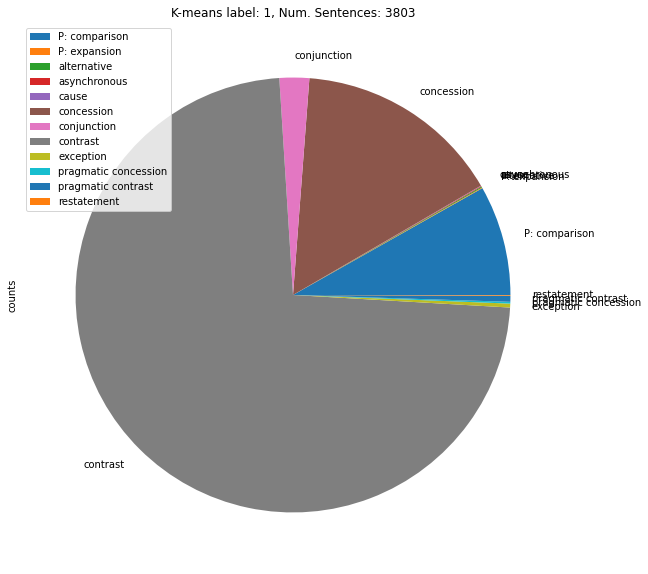

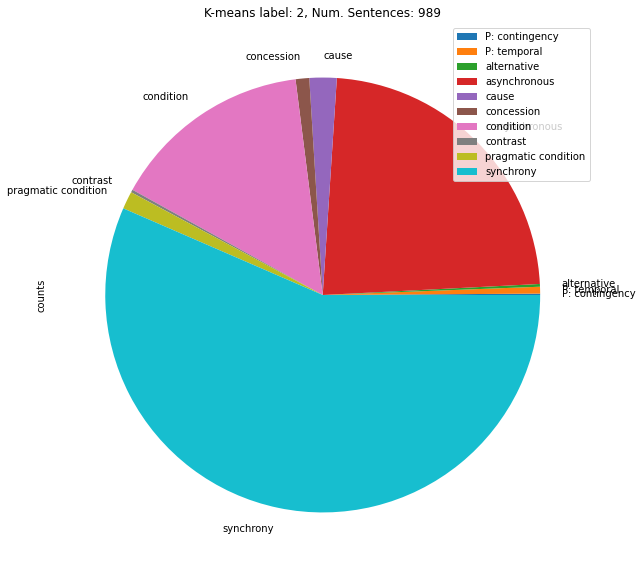

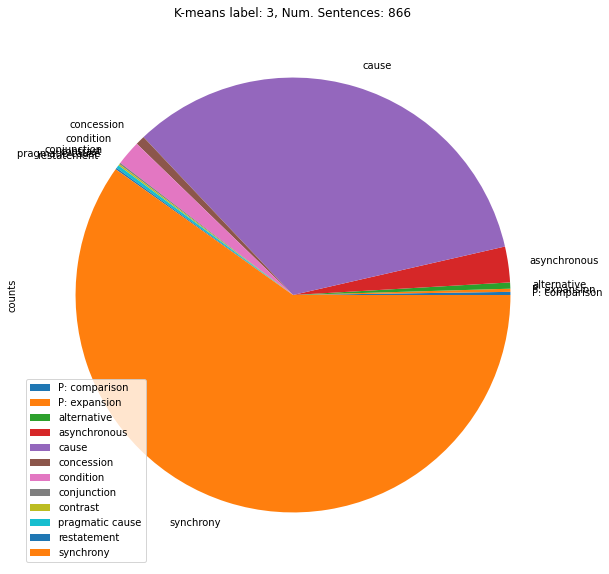

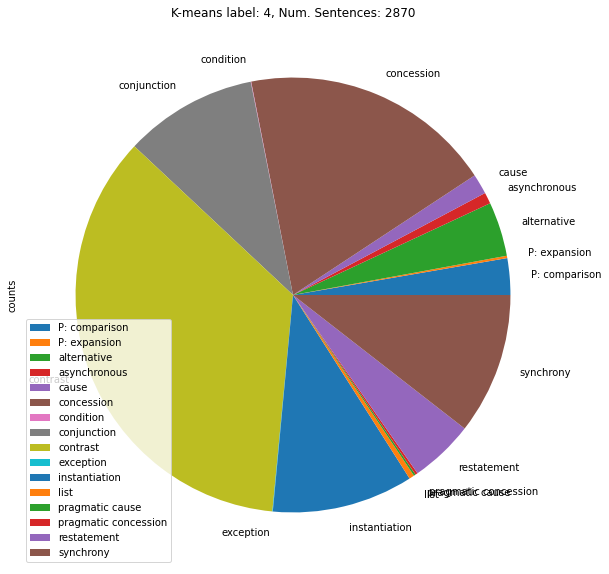

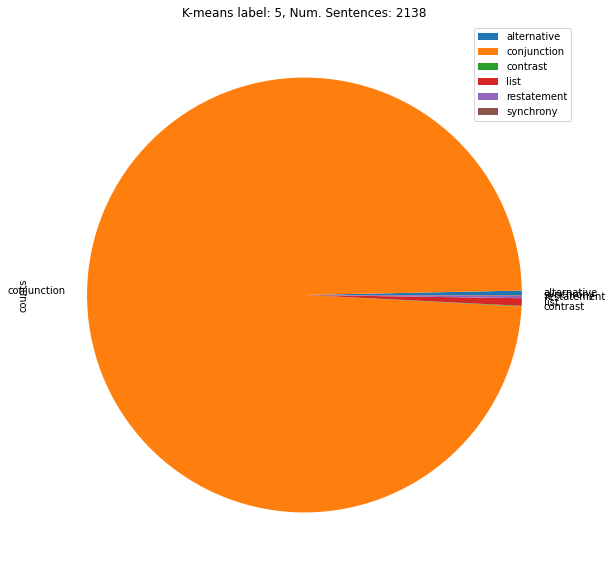

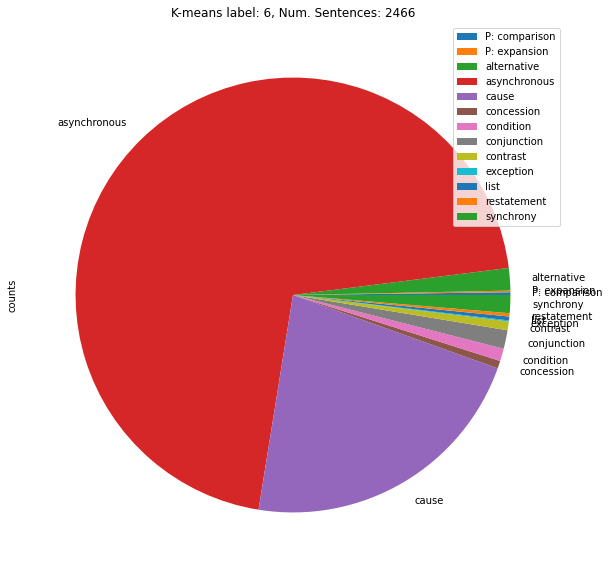

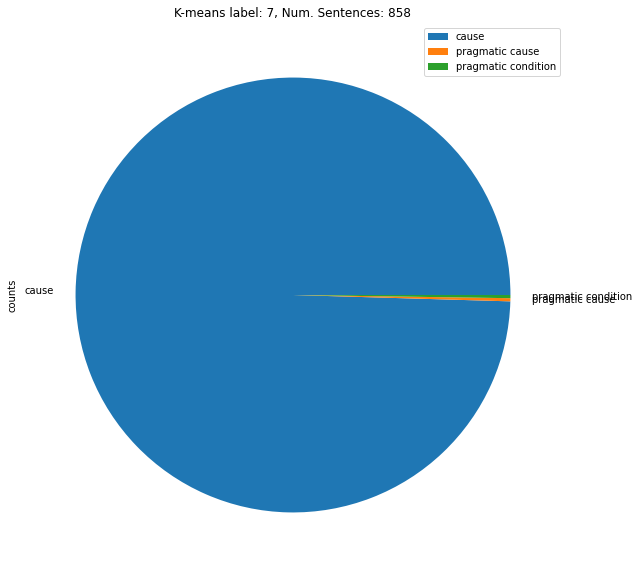

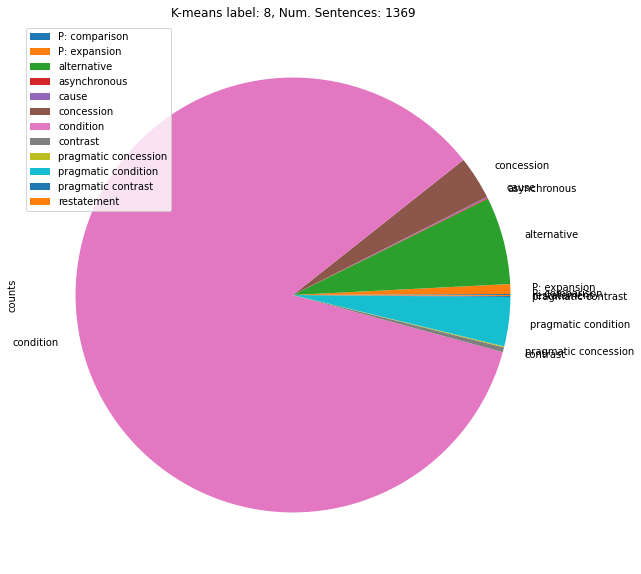

In [25]:
km.show_piechart()

# Potential Problematic Sentences

In [109]:
 # Declaring group 4 as potential problematic sentences (pps)
df = km.get_generated_class_object().get_df()
pps = df[df["algo"] == 4]
pps_indicies = pps.index.values
X_pps = [X[i] for i in pps_indicies]
X_sent_pps = [X_sentences[i] for i in pps_indicies]
rel_tag_pps = [rel_tag[i] for i in pps_indicies]

distortions_pps.pkl exists.  Loading it in...


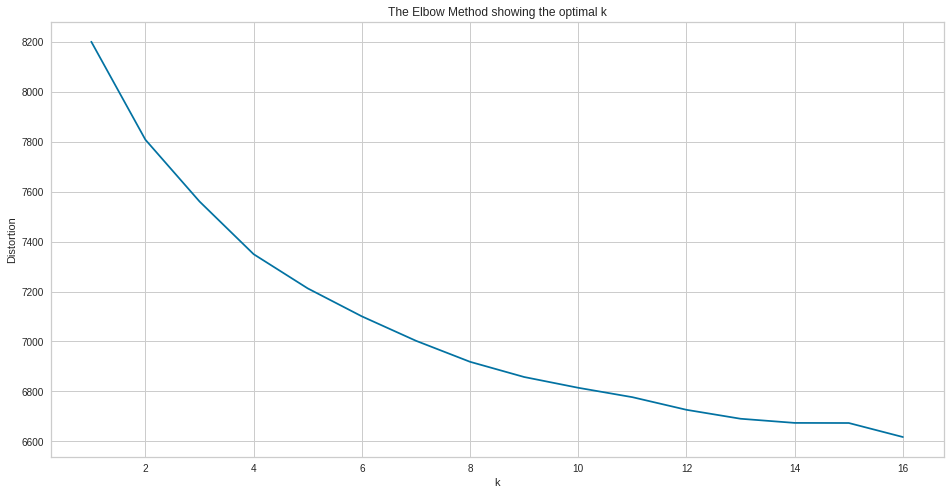

Optimal number of groups: 5


<Figure size 360x360 with 0 Axes>

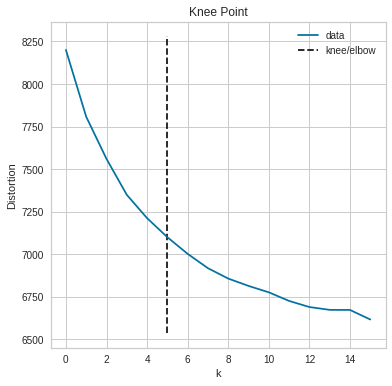

In [112]:
GetOptimalClusters(filename = "distortions_pps.pkl", 
                   representation_list = X_pps, 
                   max_clusters = 16)

In [110]:
kmeans_pps = RunKMeans(u = 5, 
                       random_state = 0,
                       X = X_pps,
                       X_sentences = X_sent_pps, 
                       rel_tag = rel_tag_pps)

In [113]:
# Reset the index for getting the pivot frame
pps = pps.reset_index(drop = True)

In [111]:
# Checking to see which categories end up in the catch-all group
# (pps.groupby(["secondary"]).count() / df.groupby(["secondary"]).count()).sort_values(["arg1"], ascending = False)

In [117]:
pps

,arg1,arg2,connective,algo,pdtb_tag,primary,secondary,tertiary,count
0,the latest results appear in today's new engla...,preliminary findings were reported more than a...,although,4,comparison.contrast,comparison,contrast,S: contrast,1
1,that hung over parts of the factory,exhaust fans ventilated the area,though,4,comparison.concession.expectation,comparison,concession,expectation,1
2,yields on money-market mutual funds continued ...,"yields ""may blip up again before they blip dow...",nevertheless,4,comparison.contrast,comparison,contrast,S: contrast,1
3,"nevertheless yields ""may blip up again before ...",the yield on six-month treasury bills sold at ...,for example,4,expansion.instantiation,expansion,instantiation,S: instantiation,1
4,"exports in october stood at $5.29 billion, a m...","imports increased sharply to $5.39 billion, up...",while,4,comparison.contrast.juxtaposition,comparison,contrast,juxtaposition,1
...,...,...,...,...,...,...,...,...,...
2865,even when a network fares well with a 100%-own...,abc made a killing in broadcasting its popular...,for example,4,expansion.instantiation,expansion,instantiation,S: instantiation,1
2866,to share in the continuing proceeds when the r...,abc will have to sell off the rights for a one...,instead,4,expansion.alternative.chosen alternative,expansion,alternative,chosen alternative,1
2867,mr. markey hopes this pushes the networks and ...,he wants the two sides to hammer out their own...,meanwhile,4,expansion.conjunction,expansion,conjunction,S: conjunction,1
2868,"a huge anc flag, with black, green and gold st...","on the street out front, boys displayed the an...",while,4,temporal.synchrony,temporal,synchrony,S: synchrony,1


In [131]:
# Replace the algo column with the newly generated ones
# This is necessary to do as the pivot table class doesn't
# behave as expected unless this is done.  
# It's something that'll have to be fixed later
new_labels = list(kmeans_pps.get_generated_class_object().get_df()[0:len(pps)]["algo"])
prepended = [float(f"4.{label}") for label in new_labels]
pps["algo"] = prepended

In [132]:
pps

,arg1,arg2,connective,algo,pdtb_tag,primary,secondary,tertiary,count
0,the latest results appear in today's new engla...,preliminary findings were reported more than a...,although,4.4,comparison.contrast,comparison,contrast,S: contrast,1
1,that hung over parts of the factory,exhaust fans ventilated the area,though,4.4,comparison.concession.expectation,comparison,concession,expectation,1
2,yields on money-market mutual funds continued ...,"yields ""may blip up again before they blip dow...",nevertheless,4.2,comparison.contrast,comparison,contrast,S: contrast,1
3,"nevertheless yields ""may blip up again before ...",the yield on six-month treasury bills sold at ...,for example,4.0,expansion.instantiation,expansion,instantiation,S: instantiation,1
4,"exports in october stood at $5.29 billion, a m...","imports increased sharply to $5.39 billion, up...",while,4.1,comparison.contrast.juxtaposition,comparison,contrast,juxtaposition,1
...,...,...,...,...,...,...,...,...,...
2865,even when a network fares well with a 100%-own...,abc made a killing in broadcasting its popular...,for example,4.0,expansion.instantiation,expansion,instantiation,S: instantiation,1
2866,to share in the continuing proceeds when the r...,abc will have to sell off the rights for a one...,instead,4.2,expansion.alternative.chosen alternative,expansion,alternative,chosen alternative,1
2867,mr. markey hopes this pushes the networks and ...,he wants the two sides to hammer out their own...,meanwhile,4.3,expansion.conjunction,expansion,conjunction,S: conjunction,1
2868,"a huge anc flag, with black, green and gold st...","on the street out front, boys displayed the an...",while,4.1,temporal.synchrony,temporal,synchrony,S: synchrony,1


In [133]:
piv_pps = Pivot(dataframe = pps)

In [136]:
piv_pps.get_table()

algo                                4.0    4.1    4.2   4.3    4.4
primary     secondary                                             
comparison  P: comparison           0.0   21.0   26.0   0.0   31.0
            concession              0.0   85.0  144.0   1.0  310.0
            contrast                0.0  410.0  271.0  28.0  309.0
            pragmatic concession    0.0    0.0    5.0   0.0    0.0
contingency cause                   0.0    0.0   43.0   0.0    0.0
            condition               0.0    0.0    1.0   0.0    0.0
            pragmatic cause         0.0    0.0    4.0   0.0    0.0
expansion   P: expansion            0.0    0.0    5.0   0.0    0.0
            alternative             0.0    0.0  116.0   0.0    0.0
            conjunction             1.0   54.0  159.0  70.0    0.0
            exception               0.0    0.0    0.0   0.0    1.0
            instantiation         298.0    0.0    3.0   0.0    0.0
            list                    0.0    9.0    2.0   0.0    0.0
            restatement            18.0    0.0  117.0   0.0    2.0
temporal    asynchronous            0.0    0.0   24.0   0.0    0.0
            synchrony               0.0  202.0    6.0  94.0    0.0

In [135]:
print(piv_pps.get_column_percent_table())

algo                               4.0   4.1   4.2   4.3   4.4
primary     secondary                                         
comparison  P: comparison          0.0   2.7   2.8   0.0   4.7
            concession             0.0  10.9  15.6   0.5  47.5
            contrast               0.0  52.5  29.3  14.5  47.3
            pragmatic concession   0.0   0.0   0.5   0.0   0.0
contingency cause                  0.0   0.0   4.6   0.0   0.0
            condition              0.0   0.0   0.1   0.0   0.0
            pragmatic cause        0.0   0.0   0.4   0.0   0.0
expansion   P: expansion           0.0   0.0   0.5   0.0   0.0
            alternative            0.0   0.0  12.5   0.0   0.0
            conjunction            0.3   6.9  17.2  36.3   0.0
            exception              0.0   0.0   0.0   0.0   0.2
            instantiation         94.0   0.0   0.3   0.0   0.0
            list                   0.0   1.2   0.2   0.0   0.0
            restatement            5.7   0.0  12.6   0.

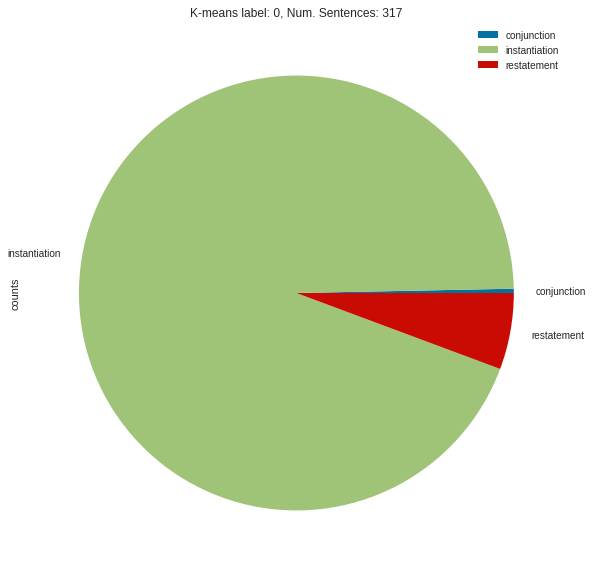

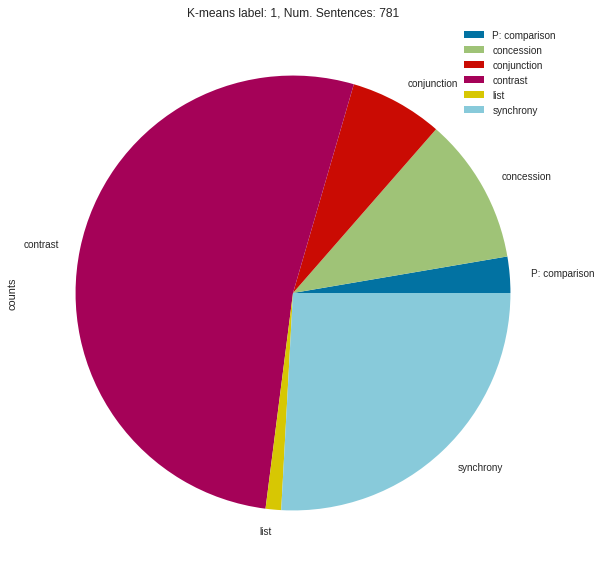

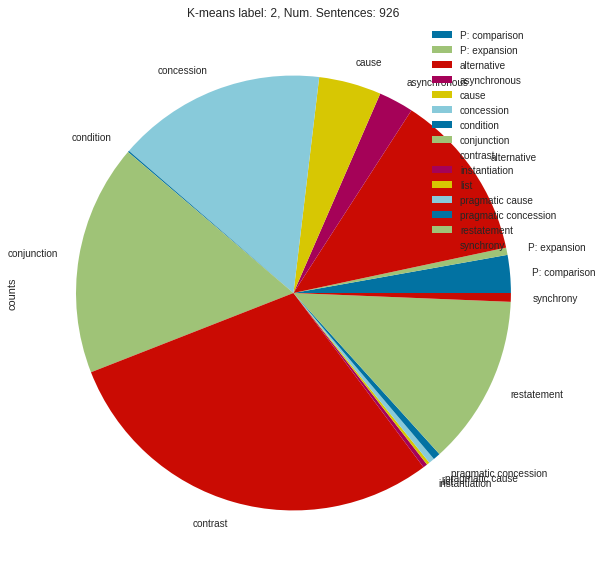

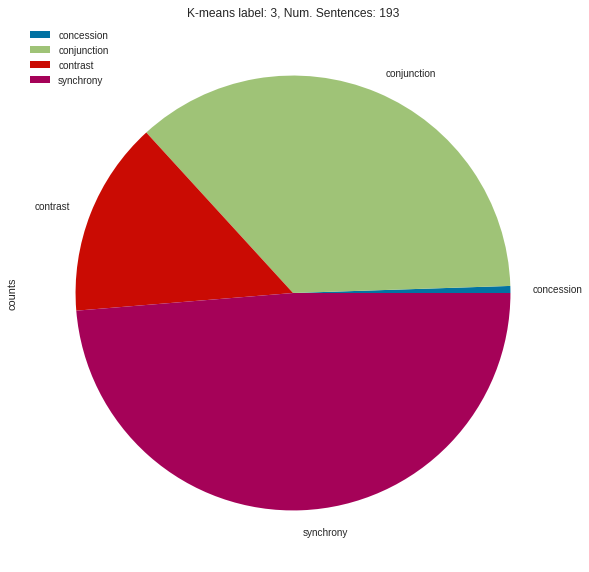

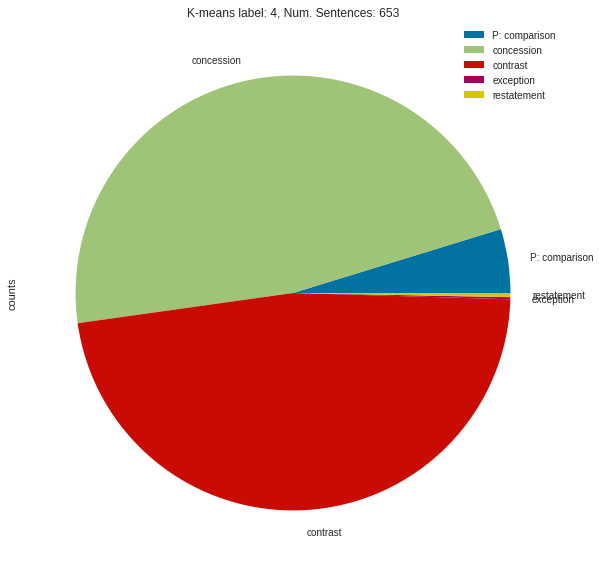

In [83]:
kmeans_pps.show_piechart()

## t-SNE Visualization using KMeans Clusters

https://builtin.com/data-science/unsupervised-learning-python
"One of the unsupervised learning methods for visualization is t-distributed stochastic neighbor embedding, or t-SNE. It maps high-dimensional space into a two or three-dimensional space which can then be visualized. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability"

In [32]:
from yellowbrick.text import TSNEVisualizer

In [46]:
# Colors for the labels:
# See: https://mokole.com/palette.html
# Hex values generated above with [Black OK, 90%] 
# as the luminosity settings with 10000 maximum loops

gold_labels = df.loc[:,"secondary"]


gold_labels_colors = ["#000000", "#808080", "#2e8b57", 
                      "#7f0000", "#808000", "#800080",
                      "#ff4500", "#ffa500", "#ffff00",
                      "#0000cd", "#7cfc00", "#00fa9a",
                      "#4169e1", "#00ffff", "#00bfff",
                      "#ff00ff", "#fa8072", "#dda0dd",
                      "#ff1493", "#f5deb3"]

algo_labels = df.loc[:, "algo"]
algo_labels_colors = ["#006400", "#bc8f8f", "#ff4500", 
                      "#ffd700", "#00ff00", "#00ffff",
                      "#a020f0", "#1e90ff", "#ff1493"]

In [36]:
set(gold_labels)

{'P: comparison',
 'P: contingency',
 'P: expansion',
 'P: temporal',
 'alternative',
 'asynchronous',
 'cause',
 'concession',
 'condition',
 'conjunction',
 'contrast',
 'exception',
 'instantiation',
 'list',
 'pragmatic cause',
 'pragmatic concession',
 'pragmatic condition',
 'pragmatic contrast',
 'restatement',
 'synchrony'}

In [50]:
# This takes 3 minutes to run
# Defining Model
#model = TSNE(learning_rate = 100)
# Fitting Model
#transformed = model.fit_transform(X)
#num_clusters = 9
#clusters = KMeans(n_clusters=num_clusters)
#clusters.fit(transformed)

# Visualization of tSNE 
# Runtime for this is about 2.5 min

#tsne = TSNEVisualizer(random_state = 0, 
#                      colors = algo_labels_colors, 
#                      alpha = 0.5)

#tsne_3d = TSNE(n_components = 3, random_state = 0)

tsne.fit(X, ["Cluster: {}".format(c) for c in list(algo_labels)])
tsne.show()

TypeError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


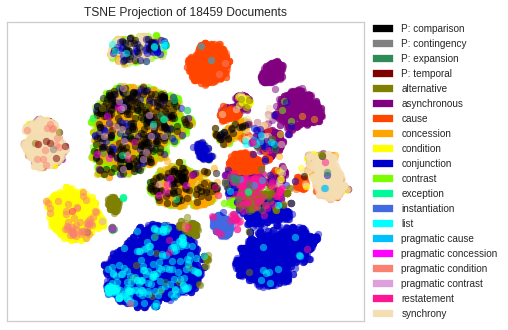

In [47]:
# Visualization of the gold labels
# Runtime for this is about 2.5 min
tsne = TSNEVisualizer(random_state = 0, 
                      colors = gold_labels_colors, 
                      alpha = 0.5)
#tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.fit(X, [format(c) for c in list(gold_labels)])
tsne.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


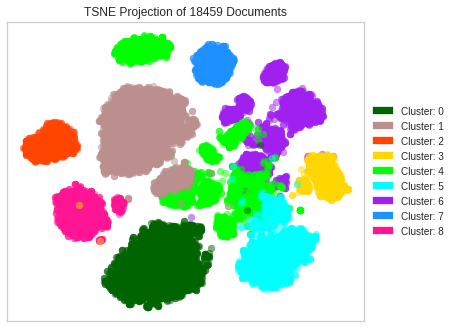

In [ ]:
# Visualization of the k-means algo labels
# Runtime for this is about 2.5 min

tsne = TSNEVisualizer(random_state = 0, colors = algo_labels_colors, 
                      alpha = 0.5)
#tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.fit(X, ["Cluster: {}".format(c) for c in algo_labels])
tsne.show()

# DBSCAN

Following: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

the linear boundary of the k-means clustering definitely does not work well. However, DBSCAN doesn’t require any shape of the clusters but tracks the high-density regions

There are a few implicit assumptions in this approach:
*   Densities across all the clusters are the same.
*   Cluster sizes or standard deviations are the same.


A large eps tend to include more points within a cluster, so a too-large eps will include everything in the same single cluster and a too-small eps will result in no clustering at all.

A too-small minPts is not meaningful because it will regard every point as a core point. A relatively larger minPts can be better to deal with data with more noises.

## Finding Parameters using nearest neighbors

In [ ]:
#use nearest neighbors to help calculate our eps argument with dbscan

In [ ]:
from sklearn.neighbors import NearestNeighbors
#https://scikit-learn.org/stable/modules/neighbors.html
#start by using sqrt(N) for number of neighbors

#two different approaches
#num_neighs = round(len(X)/11) #naively we expect around 11 clusters 
num_neighs = 100

nearest_neighbors = NearestNeighbors(n_neighbors=num_neighs)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)

Text(0, 0.5, 'Distance')

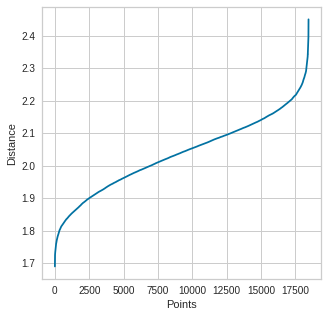

In [ ]:
#plot
distances_sorted = np.sort(distances[:,100-1], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances_sorted)
plt.xlabel("Points")
plt.ylabel("Distance")

#When num_neighs = len(X)/11 -- could look at other elbow point in data

2.178665


<Figure size 360x360 with 0 Axes>

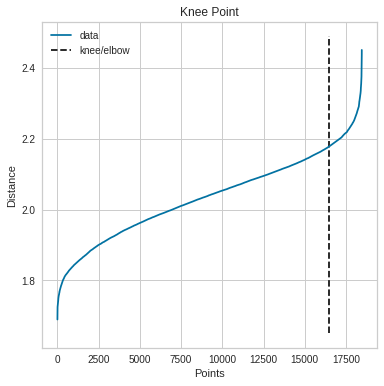

In [ ]:
#find eps from the above graph using KneeLocator to Detect Elbow Point
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances_sorted, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(knee.knee_y)

## Run Model

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=1.65, min_samples=25).fit(X)
#print(DBSCAN_cluster.labels_)

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("Num_clusters: " + str(num_clusters))
print("Percentage of points that are outliers: " + str(percentage_outliers))

Num_outliers: 17825
Num_clusters: 4
Percentage of points that are outliers: 96.56536107048052


In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1

In [ ]:
dbscan_labels = ViewLabels(X, X_sentences, DBSCAN_labels, 
                           len(set(DBSCAN_labels)), "secondary")

In [ ]:
df = dbscan_labels.get_df()
labels_DBSCAN = dbscan_labels.get_algo_labels()
connective_to_label_DBSCAN = dbscan_labels.get_connective_to_algo()

In [ ]:
# label 0 is outlier data if num_outliers > 0
labels_DBSCAN

[[0,
  [{'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'before and after',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'indeed',
    'insofar as',
    'instead',
    'later',
    'lest',
    'likewise',
    'meantime',
    'meanwhile',
    'moreover',
    'much as',
    'neither nor',


In [ ]:
u = len(labels_DBSCAN)
cols = [i for i in range(u)]
conntive_clusters = [list(x[1][0]) for x in labels_DBSCAN]
df = pd.DataFrame(conntive_clusters).transpose()
df.columns = cols
df

,0,1,2,3,4
0,but,while,moreover,as,but
1,overall,however,later,None,and
2,as though,and,instead,None,None
3,further,on the other hand,also,None,None
4,whereas,None,additionally,None,None
...,...,...,...,...,...
95,when,None,None,None,None
96,in short,None,None,None,None
97,so that,None,None,None,None
98,hence,None,None,None,None


In [ ]:
from pathlib import Path  
filepath = Path('DBSCAN_semanticEmbed_similarityConcate-16.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
#df.to_csv(filepath)  

In [ ]:
labels_DBSCAN

[[0,
  [{'accordingly',
    'additionally',
    'after',
    'afterward',
    'also',
    'alternatively',
    'although',
    'and',
    'as',
    'as a result',
    'as an alternative',
    'as if',
    'as long as',
    'as soon as',
    'as though',
    'as well',
    'because',
    'before',
    'before and after',
    'besides',
    'but',
    'by comparison',
    'by contrast',
    'by then',
    'consequently',
    'conversely',
    'earlier',
    'either or',
    'else',
    'except',
    'finally',
    'for',
    'for example',
    'for instance',
    'further',
    'furthermore',
    'hence',
    'however',
    'if',
    'if and when',
    'if then',
    'in addition',
    'in contrast',
    'in fact',
    'in other words',
    'in particular',
    'in short',
    'in sum',
    'in the end',
    'in turn',
    'indeed',
    'insofar as',
    'instead',
    'later',
    'lest',
    'likewise',
    'meantime',
    'meanwhile',
    'moreover',
    'much as',
    'neither nor',


##DBSCAN - TSNE

In [ ]:
#Def model:
model = TSNE(learning_rate = 100)

# Fitting model 
transformed = model.fit_transform(X)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


### Finding parameters with visualization

eps:1.5, num_clusters:59
eps:1.6, num_clusters:54
eps:1.7000000000000002, num_clusters:52
eps:1.8000000000000003, num_clusters:50
eps:1.9000000000000004, num_clusters:48
eps:2.0000000000000004, num_clusters:47
eps:2.1000000000000005, num_clusters:46
eps:2.2000000000000006, num_clusters:46
eps:2.3000000000000007, num_clusters:43
eps:2.400000000000001, num_clusters:41


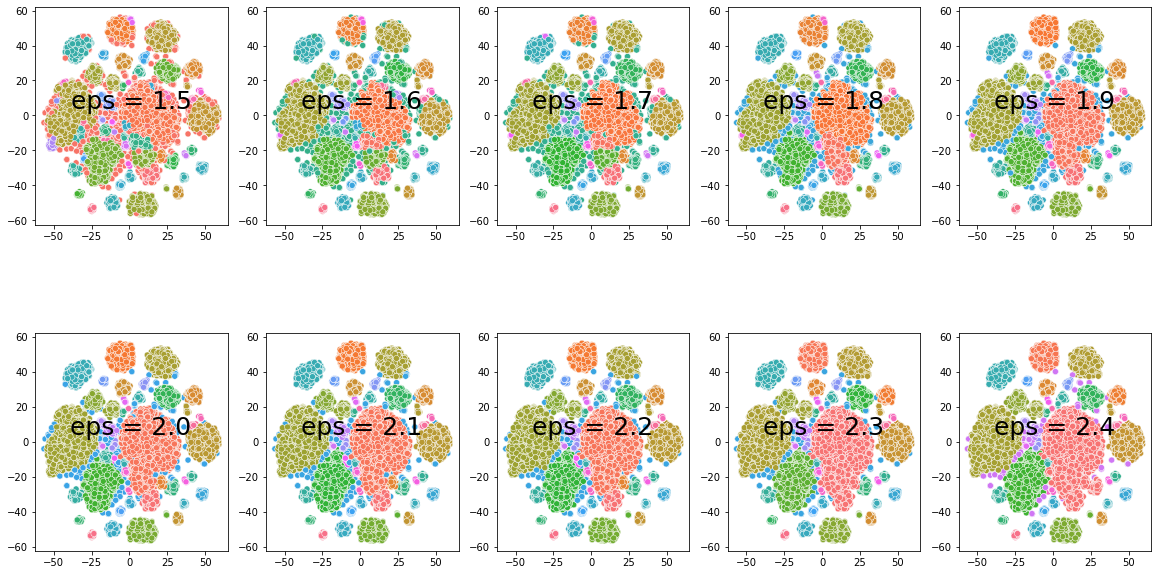

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
ran = np.arange(1.5, 2.5, 0.1)
for x in ran:
  eps = x
  db = DBSCAN(eps=eps, min_samples=20).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("eps:" + str(eps) + ", num_clusters:" + str(len(np.unique(labels))))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

In [ ]:
#finding the optimal min_samples using visualization
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
eps = 1.8
ran = np.arange(5,55,5)
for x in ran:
  min_s = x
  db = DBSCAN(eps=eps, min_samples=min_s).fit(transformed)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  print("min_samples:" + str(min_s) + ", num_clusters:" + str(len(np.unique(labels))) + ", percent_outliers: " + str((np.sum(labels == -1))/len(DBSCAN_cluster.labels_) * 100))
  ax = fig.add_subplot(2, 5, i)
  ax.text(1, 4, "m_s = {}".format(round(min_s, 1)), fontsize=25, ha="center")
  sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["cluster-{}".format(x) for x in labels], legend = False)
  i += 1

NameError: ignored

<Figure size 1440x720 with 0 Axes>

### Run model using the parameters found

In [ ]:
from sklearn.cluster import DBSCAN
eps = knee.knee_y
DBSCAN_cluster = DBSCAN(eps=1.82, min_samples=20).fit(transformed)
#print(DBSCAN_cluster.labels_)

NameError: ignored

In [ ]:
num_outliers = np.sum(DBSCAN_cluster.labels_ == -1)
num_clusters = len(np.unique(DBSCAN_cluster.labels_)) - 1
percentage_outliers = num_outliers/len(DBSCAN_cluster.labels_) * 100
print("Num_outliers: " + str(num_outliers))
print("num clusters: " + str(num_clusters))
print("percentage of points that are outliers: " + str(percentage_outliers))

In [ ]:
DBSCAN_labels = DBSCAN_cluster.labels_
if (num_outliers > 0):
  #if there are outliers in the data, shift the data up to print the unlustered data, otherwise leave as is
  DBSCAN_labels = DBSCAN_labels + 1
  
dbscan_labels = ViewLabels(X, X_sentences, DBSCAN_labels, 
                           len(set(DBSCAN_labels)), "secondary")
df = dbscan_labels.get_df()
labels_DBSCAN = dbscan_labels.get_algo_labels()
connective_to_label_DBSCAN = dbscan_labels.get_connective_to_algo()

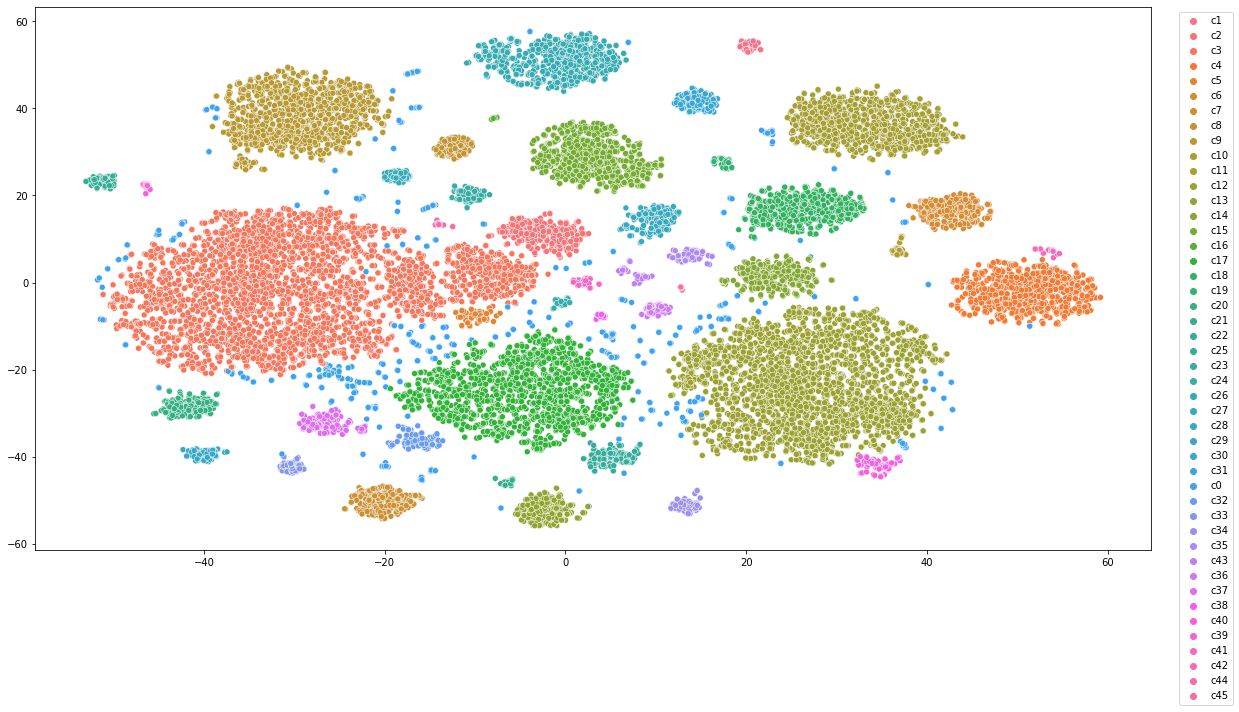

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(x = transformed[:,0], y = transformed[:,1], hue=["c{}".format(x) for x in DBSCAN_labels])
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

In [ ]:
df_count=count_label(kmeans.labels_,rel_tag)
df_count

In [ ]:
filepath = Path('similarityconcate_DBSCAN_QAEmbeddings_count.csv')  
#df_count.to_csv(filepath)

In [ ]:
for i in range(-1,43):
  df_by_klabel=df_count.loc[df_count['kmeans_label'] == i]
  total_number = df_by_klabel["counts"].sum()
  plt=df_by_klabel.set_index("secondary_tag").plot.pie(y='counts', figsize=(10, 10),fontsize=10)
  plt.set_title("kmeans label "+str(i)+", total paris: "+str(total_number))
  fig = plt.get_figure()
  #fig.savefig("output"+str(i)+".png")

# Extra Models

## Affinity Propogation

https://scikit-learn.org/stable/modules/clustering.html
"AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given."

Not enough RAM to do this

In [ ]:
from sklearn.cluster import AffinityPropagation
# Fit Affinity Propagation with Scikit
afprop = AffinityPropagation(max_iter=250)
afprop.fit(X)
cluster_centers_indices = afprop.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
# Predict the cluster for all the samples
P = afprop.predict(X)


## Mean-Shift

https://scikit-learn.org/stable/modules/clustering.html

MeanShift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [ ]:
from sklearn.cluster import MeanShift
ms = MeanShift(max_iter = 10)
ms.fit(X)


KeyboardInterrupt: ignored

In [ ]:
num_clusters = len(set(ms.labels))
ms_labels = ViewLabels(X, X_sentences, ms.labels, num_cluster, "secondary")
labels_MS = ms_labels.get_algo_labels()
connective_to_label_MS = ms_labels.get_connective_to_algo()

## Hierarchal Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 4).fit(X)
clustering.labels_